## Use Case 4: Viewer Engagement Prediction

Predicts whether a movie will achieve high or low audience engagement based on attributes such as revenue, budget, ratings, and vote count

***Import libraries & load Dataset***

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Load the dataset directly from Databricks table
df = spark.table("default.tmdb_5000_movies")

df.select("title", "budget", "revenue", "popularity", "vote_average", "vote_count").show(5)

+--------------------+---------+----------+----------+------------+----------+
|               title|   budget|   revenue|popularity|vote_average|vote_count|
+--------------------+---------+----------+----------+------------+----------+
|              Avatar|237000000|2787965087|150.437577|         7.2|     11800|
|Pirates of the Ca...|300000000| 961000000|139.082615|         6.9|      4500|
|             Spectre|245000000| 880674609|107.376788|         6.3|      4466|
|The Dark Knight R...|250000000|1084939099| 112.31295|         7.6|      9106|
|         John Carter|260000000| 284139100| 43.926995|         6.1|      2124|
+--------------------+---------+----------+----------+------------+----------+
only showing top 5 rows


***Define Viewer Engagement Label***

If popularity ≥ median → High engagement (1)

Else → Low engagement (0)

In [0]:
# Calculate median popularity
median_pop = df.approxQuantile("popularity", [0.5], 0.0)[0]

# Create binary label column
df = df.withColumn("engagement_level", when(col("popularity") >= median_pop, 1).otherwise(0))

# Check distribution
df.groupBy("engagement_level").count().show()

+----------------+-----+
|engagement_level|count|
+----------------+-----+
|               1| 2402|
|               0| 2404|
+----------------+-----+



***Feature Selection***

In [0]:
feature_cols = ["budget", "revenue", "vote_average", "vote_count"]

# Fill nulls with 0
for c in feature_cols:
    df = df.na.fill({c: 0})

# Vectorize features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "engagement_level")

data.show(5)


+--------------------+----------------+
|            features|engagement_level|
+--------------------+----------------+
|[2.37E8,2.7879650...|               1|
|[3.0E8,9.61E8,6.9...|               1|
|[2.45E8,8.8067460...|               1|
|[2.5E8,1.08493909...|               1|
|[2.6E8,2.841391E8...|               1|
+--------------------+----------------+
only showing top 5 rows


***Split Data***



In [0]:
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)
print("Training rows:", train_df.count())
print("Testing rows:", test_df.count())

Training rows: 3885
Testing rows: 921


***Train Decision Tree Model***

In [0]:
# Initialize Decision Tree Model
dt = DecisionTreeClassifier(labelCol="engagement_level", featuresCol="features", maxDepth=5)

# Train model
dt_model = dt.fit(train_df)


***Model Evaluation***

In [0]:
predictions = dt_model.transform(test_df)

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="engagement_level",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"✅ Model Accuracy: {round(accuracy, 3)}")


✅ Model Accuracy: 0.952


The Decision Tree Classifier achieved an accuracy of 95.2%, indicating that the model performs extremely well in predicting whether a movie will have high or low viewer engagement.
This high accuracy suggests that the chosen features (budget, revenue, ratings, and votes) effectively capture the factors influencing audience activity and interest

***Feature Importance***

In [0]:
# Display feature importance
for col_name, importance in zip(feature_cols, dt_model.featureImportances):
    print(f"{col_name}: {importance:.3f}")


budget: 0.004
revenue: 0.004
vote_average: 0.005
vote_count: 0.987


The feature importance values show that vote_count (0.987) overwhelmingly dominates the model’s prediction, meaning that the number of audience votes or reviews is the most powerful indicator of viewer engagement.
Other features such as vote_average, revenue, and budget contribute minimally, implying that audience activity (volume of participation) matters far more than financial or critical success.

***Visualize Feature Importance***

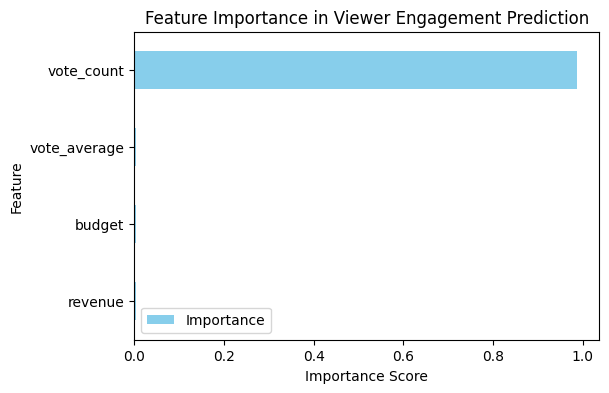

In [0]:
# Convert importance values to Pandas for plotting
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': [float(i) for i in dt_model.featureImportances]
})

importance_df.sort_values('Importance').plot(
    x='Feature', y='Importance', kind='barh', color='skyblue', figsize=(6,4),
    title='Feature Importance in Viewer Engagement Prediction'
)
plt.xlabel("Importance Score")
plt.show()


The visualization clearly highlights that vote_count has the highest importance score, nearing 1.0, while all other variables remain close to zero.
This indicates that movies which receive a large number of votes, reviews, or ratings tend to have significantly higher audience engagement, reflecting strong audience involvement and online interaction.

***Example (New Movie Prediction)***

In [0]:
from pyspark.ml.linalg import Vectors

new_movie = [(Vectors.dense([150000000, 800000000, 8.1, 19000, 140]),)]
new_df = spark.createDataFrame(new_movie, ["features"])

result = dt_model.transform(new_df)
result.select("features", "prediction").show()


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.5E8,8.0E8,8.1,...|       1.0|
+--------------------+----------+



The model predicts High Engagement (1) that means meaning this movie is likely to perform strongly with audiences.

**The model effectively predicts viewer engagement with 95.2% accuracy.
Engagement is primarily driven by vote_count, showing that active audience participation is the strongest indicator of success in digital platforms.
This insight helps streaming services and studios identify which titles are likely to generate strong viewer involvement and optimize their content promotion strategies.**